In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=True)

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

2024-05-02 14:55:06,243 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-05-02 14:55:06,243 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2024-05-02 14:55:06,243 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-05-02 14:55:06,244 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_temp_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2024-05-02 14:55:06,245 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-05-02 14:55:06,245 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("measurement")
2024-05-02 14:55:06,245 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-05-02 14:55:06,246 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("station")
2024-05-02 14:55:06,246 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-05-02 14:55:06,247 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
lastest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Display results
lastest_date

2024-05-02 14:55:14,337 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-05-02 14:55:14,341 INFO sqlalchemy.engine.Engine SELECT measurement.date AS measurement_date 
FROM measurement ORDER BY measurement.date DESC
 LIMIT ? OFFSET ?
2024-05-02 14:55:14,342 INFO sqlalchemy.engine.Engine [generated in 0.00078s] (1, 0)


('2017-08-23',)

2024-05-02 14:55:19,594 INFO sqlalchemy.engine.Engine SELECT measurement.id AS measurement_id, measurement.station AS measurement_station, measurement.date AS measurement_date, measurement.prcp AS measurement_prcp, measurement.tobs AS measurement_tobs 
FROM measurement 
WHERE measurement.date >= ? ORDER BY measurement.date
2024-05-02 14:55:19,595 INFO sqlalchemy.engine.Engine [generated in 0.00087s] ('2016-08-23',)


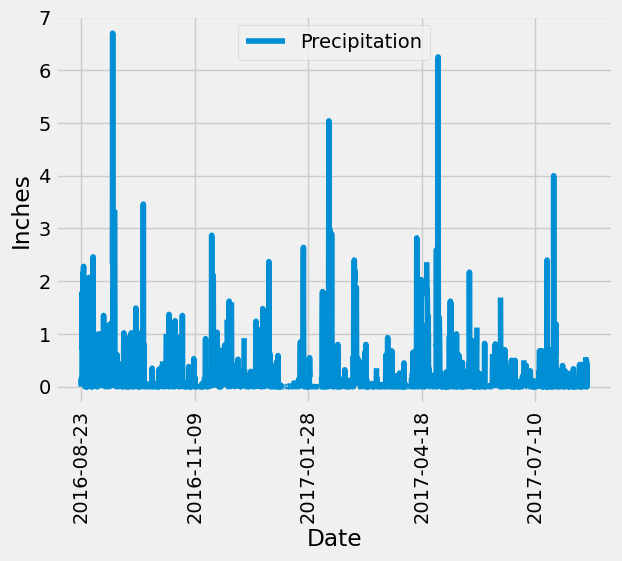

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.

# Perform a query to retrieve the data and precipitation scores
last_years_measurements = session.query(Measurement).filter(Measurement.date >= '2016-08-23').order_by(Measurement.date).all()
last_year_dates_list = [(row.date) for row in last_years_measurements]
last_years_prcp_list = [(row.prcp) for row in last_years_measurements]

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame({
    'Dates': last_year_dates_list,
    'Precipitation':last_years_prcp_list
})

# Sort the dataframe by date
df = df.sort_values('Dates', ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(kind='line', x='Dates', y='Precipitation', 
        xlabel='Date', 
        ylabel='Inches',
        rot=90)

# Show the plot
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df.describe()
summary_statistics

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations_query = session.query(func.count(Station.station)).all()

# Display result
total_stations_query

2024-05-02 14:55:25,402 INFO sqlalchemy.engine.Engine SELECT count(station.station) AS count_1 
FROM station
2024-05-02 14:55:25,404 INFO sqlalchemy.engine.Engine [generated in 0.00134s] ()


[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations_query = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .all()

# Display results
most_active_stations_query

2024-05-02 14:55:29,188 INFO sqlalchemy.engine.Engine SELECT measurement.station AS measurement_station, count(measurement.station) AS count_1 
FROM measurement GROUP BY measurement.station ORDER BY count(measurement.station) DESC
2024-05-02 14:55:29,189 INFO sqlalchemy.engine.Engine [generated in 0.00119s] ()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Store most active station id into variable
most_active_station_id = most_active_stations_query[0][0]

# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.sum(Measurement.tobs)/func.count(Measurement.tobs))\
    .filter(Measurement.station == most_active_station_id)\
    .all()

# display results
station_stats

2024-05-02 14:55:32,268 INFO sqlalchemy.engine.Engine SELECT min(measurement.tobs) AS min_1, max(measurement.tobs) AS max_1, sum(measurement.tobs) / (count(measurement.tobs) + 0.0) AS anon_1 
FROM measurement 
WHERE measurement.station = ?
2024-05-02 14:55:32,269 INFO sqlalchemy.engine.Engine [generated in 0.00097s] ('USC00519281',)


[(54.0, 85.0, 71.66378066378067)]

In [15]:
# Query to find the most recent date for the most active station 
lastest_date_most_active = session.query(Measurement.date).filter((Measurement.station == most_active_station_id)).order_by(Measurement.date.desc()).first()

# Display result
lastest_date_most_active

2024-05-02 14:55:36,600 INFO sqlalchemy.engine.Engine SELECT measurement.date AS measurement_date 
FROM measurement 
WHERE measurement.station = ? ORDER BY measurement.date DESC
 LIMIT ? OFFSET ?
2024-05-02 14:55:36,601 INFO sqlalchemy.engine.Engine [generated in 0.00103s] ('USC00519281', 1, 0)


('2017-08-18',)

2024-05-02 14:55:41,851 INFO sqlalchemy.engine.Engine SELECT measurement.tobs AS measurement_tobs 
FROM measurement 
WHERE measurement.station = ? AND measurement.date >= ?
2024-05-02 14:55:41,852 INFO sqlalchemy.engine.Engine [generated in 0.00103s] ('USC00519281', '2016-08-18')


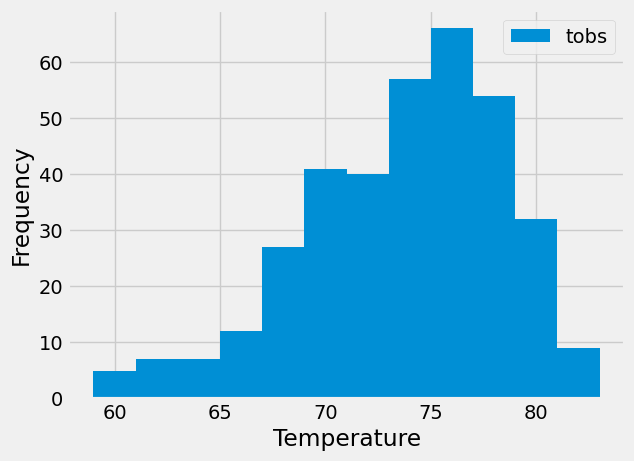

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query_results = session.query(Measurement.tobs).filter((Measurement.station == most_active_station_id)&(Measurement.date >= '2016-08-18')).all()

# Create a dataframe for the histogram plot
station_data = pd.DataFrame({
    'tobs':[row[0] for row in query_results]
})

# Create histogram
station_data['tobs'].hist(bins=12, legend=True)

# Create labels 
plt.xlabel('Temperature')
plt.ylabel('Frequency')

# Display plot
plt.show()

# Close Session

In [17]:
# Close Session
session.close()

2024-05-02 14:55:44,960 INFO sqlalchemy.engine.Engine ROLLBACK
